In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
import seaborn as sns
import tangram as tg
import warnings
warnings.simplefilter(action='ignore')

/home/wout/mambaforge/envs/tangram-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import the scRNA/snRNA data from the liver cell atlas
ad_sc = sc.read('/home/wout/Documents/Thesis_lokaal/Data_to_create_liver_atlas/adataAtlasRESOLVE.h5ad')
ad_sc=ad_sc[ad_sc.obs.typeSample=='nucSeq'] # Sparrow data was also set to 'nucleus', so makes sense to only use 'nucleus' single cell sources  

# Import the spatial data (Resolve MERFISH), this is the cell/gene matrix generated with the Sparrow pipeline   
ad_sp=sc.read('/home/wout/Documents/Thesis_lokaal/Mouse_Liver_Resolve_Data/D2-1/anndataNucD21.h5ad')
ad_sp.X=ad_sp.layers['raw_counts'] # Because the spatial data was normalized, to remove this 

In [3]:
ad_sc.obs['annotation'].value_counts()

annotation
Hepatocytes          10826
stellate              2570
LSECs                 1725
Kupffer cells          598
fibroblast             568
Mesothelial cells      522
Cholangiocytes         499
HsPCs                  413
portal_vein_EC45       378
central_vein_EC45      211
Other_ImmuneCells      154
B cells                116
VSMC                    61
LECs                    23
Endothelial cells        2
Name: count, dtype: int64

In [4]:
# 11 cell types instead of 12 (portal LAM together with other immune cells, because no annotation with portal LAM in scRNA data)
# remove cells from scrRNA-seq that are not in annotations 
ad_sc=ad_sc[ad_sc.obs.annotation!='Endothelial cells']
ad_sc=ad_sc[ad_sc.obs.annotation!='HsPCs']
ad_sc=ad_sc[ad_sc.obs.annotation!='VSMC']
ad_sc=ad_sc[ad_sc.obs.annotation!='LECs']
ad_sc.obs['annotation'] = ad_sc.obs['annotation'].replace(['stellate'], 'Stel')
ad_sc.obs['annotation'] = ad_sc.obs['annotation'].replace(['central_vein_EC45'],'Central vein')
ad_sc.obs['annotation'] = ad_sc.obs['annotation'].replace(['portal_vein_EC45'],'Portal vein')
ad_sc.obs['annotation'] = ad_sc.obs['annotation'].replace(['fibroblast'], 'Fibr')
ad_sc.obs['annotation'] = ad_sc.obs['annotation'].replace(['Other_ImmuneCells'], 'Oth im')
ad_sc.obs['annotation'] = ad_sc.obs['annotation'].replace(['Cholangiocytes'], 'Chol')
ad_sc.obs['annotation'] = ad_sc.obs['annotation'].replace(['Hepatocytes'], 'Hepa')
ad_sc.obs['annotation'] = ad_sc.obs['annotation'].replace(['Kupffer cells'], 'Kupf')
ad_sc.obs['annotation'] = ad_sc.obs['annotation'].replace(['B cells'], 'B cell')
ad_sc.obs['annotation'] = ad_sc.obs['annotation'].replace(['LSECs'], 'LSEC')
ad_sc.obs['annotation'] = ad_sc.obs['annotation'].replace(['Mesothelial cells'], 'Meso')
np.unique(ad_sc.obs['annotation'])

array(['B cell', 'Central vein', 'Chol', 'Fibr', 'Hepa', 'Kupf', 'LSEC',
       'Meso', 'Oth im', 'Portal vein', 'Stel'], dtype=object)

In [5]:
tg.pp_adatas(ad_sc,ad_sp) # if 'genes' is not specified then all overlapping genes are used for training 

INFO:root:98 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:98 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [6]:
ad_map = tg.map_cells_to_space(ad_sc,ad_sp,
    mode="cells",
    density_prior='uniform', # spatial voxels are at single cell resolution --> must be set to 'uniform'
    num_epochs=500,
    device='cpu',) 

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 98 genes and uniform density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.225, KL reg: 0.000
Score: 0.970, KL reg: 0.002
Score: 0.978, KL reg: 0.001
Score: 0.980, KL reg: 0.001
Score: 0.981, KL reg: 0.001


INFO:root:Saving results..


In [7]:
# probability that you find a cell in a voxel --> each row adds up to 1
ad_map.to_df()

cells,65,66,67,68,69,70,71,73,74,75,...,26344,26398,26408,26462,26472,26526,26589,26776,26839,26902
AATGGCTTCCTGTACC-27,1.280157e-05,1.312446e-05,7.068837e-06,1.558775e-05,5.094105e-06,2.067262e-05,2.970552e-06,2.131350e-06,3.002545e-06,7.353487e-07,...,1.536677e-06,4.425539e-06,5.204981e-06,7.535588e-06,7.828527e-06,3.303692e-06,4.348725e-06,3.040303e-06,3.620152e-06,6.440817e-06
AGTCAACAGAACAAGG-27,9.499169e-06,1.540658e-05,1.264525e-05,9.500610e-06,3.743416e-06,2.114523e-05,1.744991e-05,1.163368e-05,1.164000e-05,1.224076e-05,...,7.876763e-06,4.051854e-06,1.606466e-05,1.931673e-05,4.370462e-06,1.365450e-05,9.871857e-06,1.279254e-05,4.531538e-06,1.485268e-05
CTACTATAGGCTGGAT-27,2.731711e-06,2.177243e-06,6.238767e-06,9.423090e-07,9.052601e-06,3.527166e-06,1.009285e-06,1.922090e-05,4.516368e-06,1.961140e-05,...,5.327244e-06,1.714254e-06,4.340719e-06,2.931529e-06,8.767094e-07,3.990013e-06,8.192738e-06,1.436502e-06,2.318353e-06,4.716797e-06
CTCAACCTCAAGCTTG-27,2.643138e-06,1.142247e-06,1.009248e-06,5.247580e-07,3.122978e-07,5.608632e-07,8.635179e-07,6.272169e-07,2.350952e-06,3.401813e-07,...,8.275127e-07,3.988113e-06,5.903365e-06,8.669282e-07,1.268669e-05,8.207336e-06,1.981519e-06,3.725237e-06,7.156582e-07,4.884503e-06
GAGTTACAGCCTCATA-27,2.003311e-07,6.858237e-07,2.790294e-07,1.267085e-07,7.441657e-07,1.676093e-07,4.014393e-07,1.854660e-07,3.679414e-07,6.401347e-07,...,2.899826e-07,3.057060e-07,3.783648e-07,1.089297e-06,1.965624e-07,1.802104e-07,2.766218e-07,3.468397e-07,2.961024e-07,1.456481e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGGTTTAGAGACAAG-38,2.622820e-07,2.276170e-07,2.627738e-07,2.596713e-07,3.656609e-07,3.543836e-07,2.294484e-07,3.701423e-07,7.947926e-07,4.101678e-08,...,1.421637e-07,2.025394e-07,6.760337e-08,4.055224e-07,5.023351e-07,1.082035e-07,2.222137e-07,1.381596e-07,1.704135e-07,1.533620e-07
TTGTGTTTCGCTGTCT-38,3.674602e-07,3.569176e-07,7.906061e-07,5.418030e-07,7.556389e-08,4.324410e-06,2.479857e-07,3.694959e-07,2.036609e-07,4.234623e-07,...,2.488694e-07,2.082567e-07,1.977782e-07,4.995805e-07,1.302314e-06,2.762264e-08,6.149291e-08,1.349948e-07,9.097711e-07,1.648622e-07
TTGTTGTTCCACGTGG-38,4.043834e-07,6.409632e-07,3.348833e-07,3.628115e-06,6.183305e-07,1.170318e-06,6.391929e-07,3.068104e-07,1.562132e-06,4.772441e-07,...,2.314531e-07,4.526790e-07,5.829044e-07,9.033333e-07,5.404141e-07,2.797852e-07,7.243613e-07,1.902974e-07,4.619010e-07,5.269189e-06
TTTATGCGTACACGCC-38,4.426737e-07,2.540331e-07,1.914160e-07,2.873150e-07,9.289455e-08,6.362264e-07,1.384549e-07,6.200901e-08,2.292211e-07,2.910979e-07,...,6.770725e-08,6.566831e-08,1.508627e-07,3.789640e-07,1.479970e-07,1.387356e-07,2.035995e-07,1.704712e-07,1.484387e-07,1.913558e-07


In [8]:
ad_map.obs['annotation'] = ad_map.obs['annotation'].replace(['stellate'], 'Stel')
ad_map.obs['annotation'] = ad_map.obs['annotation'].replace(['central_vein_EC45'],'Central vein')
ad_map.obs['annotation'] = ad_map.obs['annotation'].replace(['portal_vein_EC45'],'Portal vein')
ad_map.obs['annotation'] = ad_map.obs['annotation'].replace(['fibroblast'], 'Fibr')
ad_map.obs['annotation'] = ad_map.obs['annotation'].replace(['Other_ImmuneCells'], 'Oth im')
ad_map.obs['annotation'] = ad_map.obs['annotation'].replace(['Cholangiocytes'], 'Chol')
ad_map.obs['annotation'] = ad_map.obs['annotation'].replace(['Hepatocytes'], 'Hepa')
ad_map.obs['annotation'] = ad_map.obs['annotation'].replace(['Kupffer cells'], 'Kupf')
ad_map.obs['annotation'] = ad_map.obs['annotation'].replace(['B cells'], 'B cell')
ad_map.obs['annotation'] = ad_map.obs['annotation'].replace(['LSECs'], 'LSEC')
ad_map.obs['annotation'] = ad_map.obs['annotation'].replace(['Mesothelial cells'], 'Meso')
tg.project_cell_annotations(ad_map, ad_sp, annotation="annotation")
annotations = list(pd.unique(ad_map.obs['annotation']))

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [9]:
# tg.plot_cell_annotation_sc(ad_sp,annotations,perc=0.02)
# plot fails?

In [10]:
# ad_map.X.T @ one_hot_cell_annotation_matrix
# rows no longer add up to 1!
ad_sp.obsm['tangram_ct_pred']

,Stel,Meso,LSEC,Portal vein,Hepa,Chol,Fibr,Central vein,Oth im,B cell,Kupf
cells,,,,,,,,,,,
65,0.256112,0.046421,0.791766,0.062242,0.227985,0.013491,0.015407,0.001127,0.000987,0.023013,0.000781
66,0.087394,0.037935,0.125710,0.000731,1.164645,0.004381,0.008729,0.003306,0.001411,0.000791,0.000948
67,0.036876,0.026428,0.003267,0.000663,1.354568,0.004467,0.008181,0.000979,0.000995,0.000641,0.000978
68,0.054461,0.123867,0.520662,0.000703,0.443628,0.187793,0.006821,0.000927,0.001026,0.000711,0.091307
69,0.052276,0.038849,0.364797,0.065646,0.868831,0.003994,0.017845,0.023966,0.001009,0.000817,0.000896
...,...,...,...,...,...,...,...,...,...,...,...
26526,0.005521,0.014875,0.002367,0.000548,1.394916,0.002601,0.006871,0.000628,0.001136,0.000638,0.006328
26589,0.033734,0.018300,0.002504,0.000535,1.360578,0.002797,0.004792,0.000537,0.001072,0.000640,0.000802
26776,0.041486,0.027546,0.132137,0.000971,0.540319,0.517763,0.076060,0.001355,0.092487,0.000751,0.000878


In [11]:
ad_sp.obs['tangram'] = ad_sp.obsm['tangram_ct_pred'].idxmax(axis=1).to_list()


In [12]:
# get max value of each row
max_scores = ad_sp.obsm['tangram_ct_pred'].max(axis=1)
# get second highest value of each row
second_scores = ad_sp.obsm['tangram_ct_pred'].apply(lambda x: x.nlargest(2).values[-1], axis=1)
cleanliness = (max_scores - second_scores) / ((abs(max_scores) + abs(second_scores)) / 2)
ad_sp.obs['tangram_cleanliness'] = cleanliness

In [13]:
ad_sp.obs

,region,instance,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_2_genes,pct_counts_in_top_5_genes,n_counts,shapeSize,...,Monocytes,LECs,Cleanliness,annotation,Hep,annotationSave,uniform_density,rna_count_based_density,tangram,tangram_cleanliness
cells,,,,,,,,,,,,,,,,,,,,,
65,1,1,14,2.708050,51,3.951244,49.019608,76.470588,51,1812.0,...,-0.004369,-0.043440,0.000000,LSEC Portal,0,LSEC Portal,0.00008,0.000031,LSEC,1.022361
66,1,1,6,1.945910,42,3.761200,88.095238,97.619048,42,1499.0,...,0.041207,0.032290,1.362975,HepatocytesPortal,0,HepatocytesPortal,0.00008,0.000025,Hepa,1.610308
67,1,1,5,1.791759,176,5.176150,89.772727,100.000000,176,4616.0,...,-0.051394,0.041552,1.543022,HepatocytesCentral,1,HepatocytesCentral,0.00008,0.000107,Hepa,1.893991
68,1,1,8,2.197225,27,3.332205,66.666667,88.888889,27,1331.0,...,-0.011769,0.000000,1.074100,Kupffer cells,0,Kupffer cells,0.00008,0.000016,LSEC,0.159774
69,1,1,10,2.397895,42,3.761200,52.380952,83.333333,42,3804.0,...,0.012895,-0.004325,0.000000,LSEC Portal,0,LSEC Portal,0.00008,0.000025,Hepa,0.817157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26526,1,1,12,2.564949,209,5.347108,76.076555,93.301435,209,3368.0,...,0.031721,0.014352,0.422330,HepatocytesPortal,1,HepatocytesPortal,0.00008,0.000126,Hepa,1.957794
26589,1,1,10,2.397895,197,5.288267,79.695431,94.416244,197,3620.0,...,-0.033827,0.072139,0.349909,HepatocytesPortal,1,HepatocytesPortal,0.00008,0.000119,Hepa,1.903223
26776,1,1,13,2.639057,52,3.970292,51.923077,76.923077,52,1731.0,...,0.015199,0.000498,0.000000,LSEC Portal,0,LSEC Portal,0.00008,0.000031,Hepa,0.042636


In [14]:
# rename column 'tangram' to 'annotation_tangram' ad_sp.obs.columns
ad_sp.obs.rename(columns={"tangram": 'annotation_tangram'},inplace=True)
ad_sp.uns['tangram'] = ad_sp.obsm['tangram_ct_pred']

In [15]:
ad_sp.write_h5ad('/home/wout/Documents/Thesis_lokaal/Mouse_Liver_Resolve_Data/D2-1/anndataNucD21_tangram.h5ad')

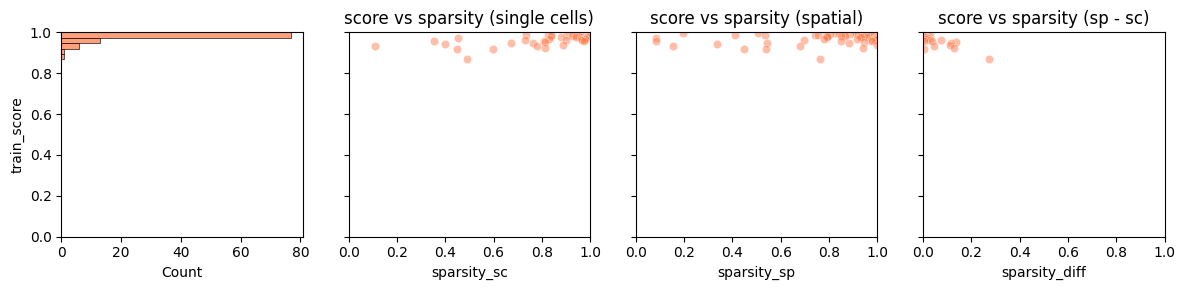

In [16]:
# How well do the counts of the mapped cell correspond with the measured counts in the spatial data (cosine similarity)
# Done for each training gene
tg.plot_training_scores(ad_map, bins=5, alpha=.5)

In [17]:
ad_map.uns['train_genes_df']

,train_score,sparsity_sc,sparsity_sp,sparsity_diff
spn,0.999875,0.999089,0.969897,-0.029193
cd3e,0.999731,0.998982,0.975508,-0.023474
chil3,0.999730,0.999786,0.990470,-0.009315
mmp12,0.999730,0.998446,0.792216,-0.206230
siglech,0.999583,0.999518,0.990381,-0.009137
...,...,...,...,...
ghr,0.931616,0.107200,0.153634,0.046434
nrxn1,0.921732,0.812600,0.942287,0.129687
slc40a1,0.920432,0.598468,0.539010,-0.059458
cyp2e1,0.918932,0.447177,0.449412,0.002235


In [18]:
# Predicted spatial expression of all genes based on mapped single cell data  
ad_ge = tg.project_genes(adata_map=ad_map, adata_sc=ad_sc)
ad_ge 

AnnData object with n_obs × n_vars = 11228 × 24212
    obs: 'region', 'instance', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_2_genes', 'pct_counts_in_top_5_genes', 'n_counts', 'shapeSize', 'uniform_density', 'rna_count_based_density'
    var: 'n_cells', 'sparsity', 'is_training'
    uns: 'annot_colors', 'training_genes', 'overlap_genes'

In [19]:
ad_ge.to_df().head()

,xkr4,gm1992,gm37381,rp1,sox17,mrpl15,lypla1,gm37988,tcea1,rgs20,...,ac132444.1,ac132444.5,csprs,ac132444.6,ac125149.3,ac168977.2,ac168977.1,ac149090.1,caaa01118383.1,caaa01147332.1
cells,,,,,,,,,,,,,,,,,,,,,
64,0.243317,0.000205,0.000013,0.000318,0.004587,0.657281,0.000359,0.154656,0.141839,0.085683,...,0.000015,0.000141,0.001812,3.511835e-06,0.000568,0.000030,0.000187,7.462193,0.763330,0.000069
66,0.507405,0.046902,0.000016,0.000379,0.017113,0.076391,0.000058,0.044191,0.035645,0.000480,...,0.000016,0.000090,0.000260,6.113416e-08,0.000413,0.000043,0.000031,2.933502,0.042840,0.004387
67,1.999756,0.000453,0.000014,0.000149,0.000860,0.008155,0.000035,0.022590,0.006357,0.001132,...,0.000006,0.000020,0.000523,2.244048e-07,0.000145,0.000012,0.000010,0.404297,0.020075,0.000038
68,0.214861,0.000209,0.000026,0.000321,0.004218,0.186937,0.000107,0.617922,0.012326,0.000806,...,0.000030,0.000179,0.000611,6.371517e-07,0.000665,0.000026,0.000045,2.559519,0.017266,0.000086
69,0.102434,0.000258,0.000034,0.000304,0.007575,0.025998,0.000075,0.011041,0.047639,0.135839,...,0.000007,0.000097,0.000550,2.514240e-07,0.000674,0.000030,0.000174,1.586848,0.561272,0.000089


In [20]:
genes = ['spn','chil3','mmp12','cxcl12'] # some training genes
# tg.plot_genes_sc(genes, adata_measured=ad_sp, adata_predicted=ad_ge, perc=0.02)
# plot fails?

In [21]:
# Leave-one-out cross-validation strategy (maybe not so interesting because we have so few genes)
# Should be run on the gpu
cv_dict, ad_ge_cv, test_gene_df = tg.cross_val(
                                     ad_sc,
                                     ad_sp,
                                     # cluster_label = 'annot', (for 'clusters' mode)
                                     mode='cells',
                                     device='cuda:0',
                                     cv_mode='loo', # also 10fold is possible
                                     return_gene_pred = True,
                                     density_prior = 'uniform',
                                     verbose = True, # print training details
                                    )

  0%|          | 0/98 [00:00<?, ?it/s]


RuntimeError: cuda runtime error (100) : no CUDA-capable device is detected at /tmp/pip-req-build-8yht7tdu/aten/src/THC/THCGeneral.cpp:50

In [22]:
### Same but with mode = clusters

In [23]:
ad_map_cl = tg.map_cells_to_space(ad_sc,ad_sp,
    mode="clusters",
    density_prior='uniform', # spatial voxels are at single cell resolution --> must be set to 'uniform'
    num_epochs=500,
    device='cpu',
    cluster_label='annotation')

Score: 0.151, KL reg: 0.184
Score: 0.553, KL reg: 0.009
Score: 0.554, KL reg: 0.009
Score: 0.554, KL reg: 0.009
Score: 0.555, KL reg: 0.009


In [24]:
ad_map_cl.to_df()

cells,64,66,67,68,69,71,72,73,74,77,...,28693,28743,28756,28866,28881,28929,28944,28992,29115,29130
0,1.279621e-04,3.150262e-05,2.237262e-07,0.000072,0.000083,1.125501e-04,1.250547e-04,1.269254e-04,1.522735e-04,1.478148e-04,...,1.414425e-04,0.000086,2.542813e-06,1.235291e-04,1.415911e-04,0.000098,1.398396e-04,1.120238e-04,5.040070e-07,0.000031
1,2.695018e-05,5.547802e-06,7.021463e-07,0.000011,0.000090,3.927615e-05,4.988465e-05,7.491511e-05,3.062766e-05,3.858249e-05,...,5.091207e-05,0.000077,2.194325e-05,4.047665e-05,2.812825e-05,0.000084,3.018536e-05,4.675505e-05,7.997298e-04,0.000007
2,3.264363e-06,1.708250e-06,2.755431e-06,0.000053,0.000072,1.721153e-05,6.645492e-06,3.041040e-06,3.440251e-07,3.547564e-07,...,4.514788e-08,0.000072,9.438446e-04,1.745196e-05,3.969612e-06,0.000048,1.363962e-07,2.426222e-05,1.343731e-07,0.000062
3,3.936068e-05,2.302329e-06,3.849526e-07,0.000013,0.000047,1.820017e-05,3.636657e-05,5.127103e-06,1.013611e-06,3.593776e-07,...,8.927903e-05,0.000047,1.549515e-06,1.437640e-05,8.471548e-07,0.000035,1.664467e-06,2.038318e-05,4.256797e-07,0.000003
4,1.247251e-06,5.775995e-04,1.649241e-07,0.000002,0.000008,4.831480e-06,1.731268e-07,3.308878e-07,1.100098e-07,3.485973e-07,...,1.761254e-06,0.000003,6.785402e-05,7.603283e-07,8.959728e-07,0.000004,1.086895e-07,1.346078e-04,7.393338e-07,0.001994
5,6.684597e-05,2.725261e-05,1.519812e-06,0.000038,0.000050,7.774338e-05,1.785475e-05,7.420561e-06,8.565697e-07,3.171821e-07,...,4.695190e-07,0.000050,3.503018e-06,2.389101e-05,4.342915e-05,0.000040,3.136749e-06,2.224670e-05,1.300474e-07,0.000160
6,2.241175e-05,3.883283e-04,6.732641e-04,0.000341,0.000006,1.206222e-05,8.954228e-06,3.998883e-06,1.486125e-05,4.102442e-07,...,7.531194e-05,0.000014,4.296284e-06,1.142472e-05,8.282228e-06,0.000004,3.500895e-06,9.065444e-06,1.269972e-06,0.000007
7,8.991234e-05,1.243774e-03,3.353831e-03,0.000715,0.000178,1.113501e-04,7.947311e-05,4.963464e-05,3.062743e-06,3.538782e-07,...,5.005377e-07,0.000177,1.680670e-06,1.051577e-04,2.941578e-05,0.000146,4.418842e-05,1.089770e-04,7.227192e-08,0.000006
8,6.405715e-06,3.892404e-06,1.897493e-07,0.000004,0.000112,1.697559e-04,1.650777e-06,1.818199e-06,1.826152e-07,2.678907e-07,...,4.506895e-07,0.000106,2.349275e-07,2.271079e-06,6.238049e-07,0.000034,3.604915e-06,7.722488e-06,1.846586e-07,0.000001
9,4.362018e-07,9.211690e-07,3.115111e-07,0.000009,0.000006,4.118870e-07,8.493031e-07,5.918144e-07,1.484893e-06,2.020842e-07,...,3.631024e-07,0.000005,1.833516e-07,1.598297e-06,1.451071e-06,0.000003,9.715382e-07,2.518749e-07,1.036660e-07,0.000003


In [25]:
ad_map_cl.obs['annotation']

0      Hepa
1      Stel
2      LSEC
3       Oth
4      Kupf
5      Endo
6      Fibr
7      Meso
8      Chol
9    B cell
Name: annotation, dtype: category
Categories (10, object): ['B cell', 'Chol', 'Endo', 'Hepa', ..., 'LSEC', 'Meso', 'Fibr', 'Stel']

In [26]:
ad_sp.obs['tangram_cl'] = ad_map_cl.to_df().idxmax(axis=0).to_list()
ad_sp.obs['tangram_cl'].replace(ad_map_cl.obs['annotation'].index.to_list(),ad_map_cl.obs['annotation'].to_list(), inplace=True)

In [27]:
# get max value of each row
max_scores = ad_map_cl.to_df().max(axis=0)
# get second highest value of each row
second_scores = ad_map_cl.to_df().apply(lambda x: x.nlargest(2).values[-1], axis=0)
cleanliness = (max_scores - second_scores) / ((abs(max_scores) + abs(second_scores)) / 2)
ad_sp.obs['tangram_cleanliness_cl'] = cleanliness

In [28]:
ad_sp.obs

,region,instance,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_2_genes,pct_counts_in_top_5_genes,n_counts,shapeSize,uniform_density,rna_count_based_density,tangram,tangram_cleanliness,tangram_cl,tangram_cleanliness_cl
cells,,,,,,,,,,,,,,,,
64,1,1,12,2.564949,150,5.017280,74.666667,92.000000,150,2545.0,0.000089,0.000105,Hepa,1.598467,Hepa,0.349282
66,1,1,16,2.833213,38,3.663562,36.842105,68.421053,38,1257.0,0.000089,0.000026,Kupf,0.507414,Meso,0.731508
67,1,1,15,2.772589,50,3.931826,52.000000,76.000000,50,3057.0,0.000089,0.000035,Meso,0.871606,Meso,1.331266
68,1,1,8,2.197225,84,4.442651,80.952381,95.238095,84,2071.0,0.000089,0.000059,Hepa,1.618017,Meso,0.709308
69,1,1,6,1.945910,52,3.970292,67.307692,98.076923,52,1637.0,0.000089,0.000036,Fibr,0.602986,Meso,0.454519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28929,1,1,8,2.197225,108,4.691348,87.037037,97.222222,108,2285.0,0.000089,0.000075,Hepa,1.665446,Meso,0.390769
28944,1,1,11,2.484907,155,5.049856,71.612903,92.258065,155,1942.0,0.000089,0.000108,Hepa,1.886565,Hepa,1.039528
28992,1,1,10,2.397895,132,4.890349,71.969697,94.696970,132,3627.0,0.000089,0.000092,Hepa,0.794310,Kupf,0.183139


In [29]:
ad_sp.write_h5ad('/home/wout/Documents/Thesis_lokaal/Mouse_Liver_Resolve_Data/anndataNucA11_tangram.h5ad')